# **The Semantle Project**

Quinn Wai Wong

---



# 👋 Introduction

Hello and welcome! Initially, my lofty goals were to both solve Semantle as efficiently as possible while learning more about the definition of word similarity within the game itself. Despite having access to the large repoisitory of source code (private as of May 11, 20222) and a lot of background information supplied by the developer on the [website](https://semantle.com/), I realized this was a challenge more more focused on the programming than the linguistics, so I transitioned my anaysis to focus more on the semantics: figuring out how word similarity is defined in Semantle.

I'll outline two different methods that I tried to visualize the ~3000 most frequent words--clustering and network science--then analyze what linguistic information I can glean from it. Rambling intro aside, let's get into it!

_**Note**: To actually edit and run the notebook, add this file to Google Drive and run it on Colab. Then, add [this folder](https://drive.google.com/drive/folders/1RXYdSQNGzrpw_vBEr8dT0k5jP4xZvtRF?usp=sharing) to your "My Drive"! It contains all of the files, as well as cool images for the final analysis. Enjoy!_

In [ ]:
# # if packages not working, uncomment and try this

# !pip uninstall networkx
# !pip uninstall python-louvain
# !pip uninstall community
# !pip install python-louvain
# !pip install networkx

Found existing installation: networkx 2.6.3
Uninstalling networkx-2.6.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/networkx-2.6.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/networkx/*
    /usr/local/share/doc/networkx-2.6.3/LICENSE.txt
    /usr/local/share/doc/networkx-2.6.3/examples/3d_drawing/README.txt
    /usr/local/share/doc/networkx-2.6.3/examples/3d_drawing/mayavi2_spring.py
    /usr/local/share/doc/networkx-2.6.3/examples/3d_drawing/plot_basic.py
    /usr/local/share/doc/networkx-2.6.3/examples/README.txt
    /usr/local/share/doc/networkx-2.6.3/examples/algorithms/README.txt
    /usr/local/share/doc/networkx-2.6.3/examples/algorithms/WormNet.v3.benchmark.txt
    /usr/local/share/doc/networkx-2.6.3/examples/algorithms/hartford_drug.edgelist
    /usr/local/share/doc/networkx-2.6.3/examples/algorithms/plot_beam_search.py
    /usr/local/share/doc/networkx-2.6.3/examples/algorithms/plot_betweenness_centrality.py
    /usr/local/share/doc/networkx-2.6.3/ex

In [ ]:
# just imports... a lot of them
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from tqdm import tqdm
import regex as re
from os.path import exists

from nltk.corpus import stopwords
from nltk import word_tokenize
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import networkx as nx
import community

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

%matplotlib inline
%config InlineBackend.figure_format='retina'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# 🔎 Preprocessing

Organizing the data in a useful way...

The first step in preprocessing was to download and load a set of Word2Vec vectors that I can use for comparisons (Word2Vec [presentation](https://docs.google.com/presentation/d/1Pct3wSPO36n2uqs8ES-Sg47M_NxuIalz3h1f6JGWMoI/edit#slide=id.p) and [article](https://towardsdatascience.com/word2vec-explained-49c52b4ccb71) for reference). The most difficult part of this process was that I was unable to load such a large file (over 3GB) into my computer, so instead I had to load it in using a memory map (mmap), where only the necessary, smaller parts of the file are loaded into memory. 

The main goal of this section is to get the set of words used as targets in Semantle as a example set of words. In specific, these are an initial 5000 most frequent words in the dataset minus stopwords, capitalized words, words with hyphens, and words with spaces. In doing so, I unfortunately realized I've spoiled the game for myself, but I guess that's the cost of trying to take on such a massive dataset of word embedding vectors and only being able to use a little part of it 🤷.

In [ ]:
# load in keyed vectors file
path = "/content/drive/MyDrive/Word2Vec/"
google_vectors = KeyedVectors.load(path+"word2vec.wordvectors", mmap='r')
print(f"Google KeyedVector shape: {google_vectors.get_vector('queen').shape}")

# # For info about model, run this:
# gensim.downloader.info("word2vec-google-news-300")

Google KeyedVector shape: (300,)


In [ ]:
# load in numpy file
vectors_np = np.load(path+"word2vec.wordvectors.vectors.npy", mmap_mode = 'r')
print(f"Numpy Array Shape: {vectors_np.shape}")

Numpy Array Shape: (3000000, 300)


In [ ]:
# get word from vector
def get_word(vector):
  [word_and_score] =  google_vectors.most_similar([vector], topn=1)
  word, score = word_and_score
  if round(score, 3) == 1.000: return word
  else: raise Exception(f"Word '{word}' has score of {score:.3f}")
  
get_word(vectors_np[0,:])

'</s>'

In [ ]:
# get list of most popular words
pop_words_path = path+"popular_words.npy"
num_pop_words = 5000
pop_np = vectors_np[0:num_pop_words,:]
if exists(pop_words_path):
  pop_words = np.load(pop_words_path)
else:
  pop_words = [get_word(vectors_np[i,:]) for i in tqdm(range(num_pop_words))]
  np.save(path+"popular_words", np.array(pop_words))

pop_words[0:20]

array(['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with',
       'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by',
       'are'], dtype='<U23')

In [ ]:
# filter for stop words, spaces, and capital letters
stop_words = set(stopwords.words('english'))
stopped_idxs = np.array([word in stop_words for word in pop_words])
nonword_idxs = np.array([re.match("[a-z]+$", word) is None for word in pop_words])
cleanup_idxs = ~ np.logical_or(stopped_idxs, nonword_idxs) # all filtered word indices

vectors_cleaned = pop_np[cleanup_idxs,:]
pop_cleaned = pop_words[cleanup_idxs]

print(f"Total Number of Cleaned Words: {len(pop_cleaned)}")
print(f"Examples: {pop_cleaned[:10]}")

Total Number of Cleaned Words: 3713
Examples: ['said' 'year' 'one' 'would' 'also' 'two' 'first' 'time' 'last' 'new']


# 🍇 Clustering

My first attempt was to try and clustering the data using the outputs of the word2vec vectors. The general idea was as follows: normalize all word vector embeddings (mean of 0 and std of 1), reduce the dimensionality from 300 to 2 (so I could visualize it), then run k-means to try and find clusters of words (to hopefully infer some meaning from the word similarities!). Unfortunately \[Spoiler Alert!\], this method proved ineffective very quickly. Take a look...

In [ ]:
# normalize vectors
vectors_normed = StandardScaler().fit_transform(vectors_cleaned)

# run PCA: a way to reduce dimensions of each individual word vector
# while attempting to retain as much of the information as possible
pca = PCA(n_components=2).fit(vectors_normed)
print("Variance Explained:", pca.explained_variance_ratio_)
vectors_2d = pca.transform(vectors_normed)

Variance Explained: [0.02435631 0.02172541]


As shown above, the compression of data from 300 dimensions to 2 inevitably meant we lost a lot of information from the data, specifically 95.4% of it. That's what the print line above says. In short, the variance explained here is just the percentage of the spread/variance from the original 300D dataset that the new 2D dataset captures.

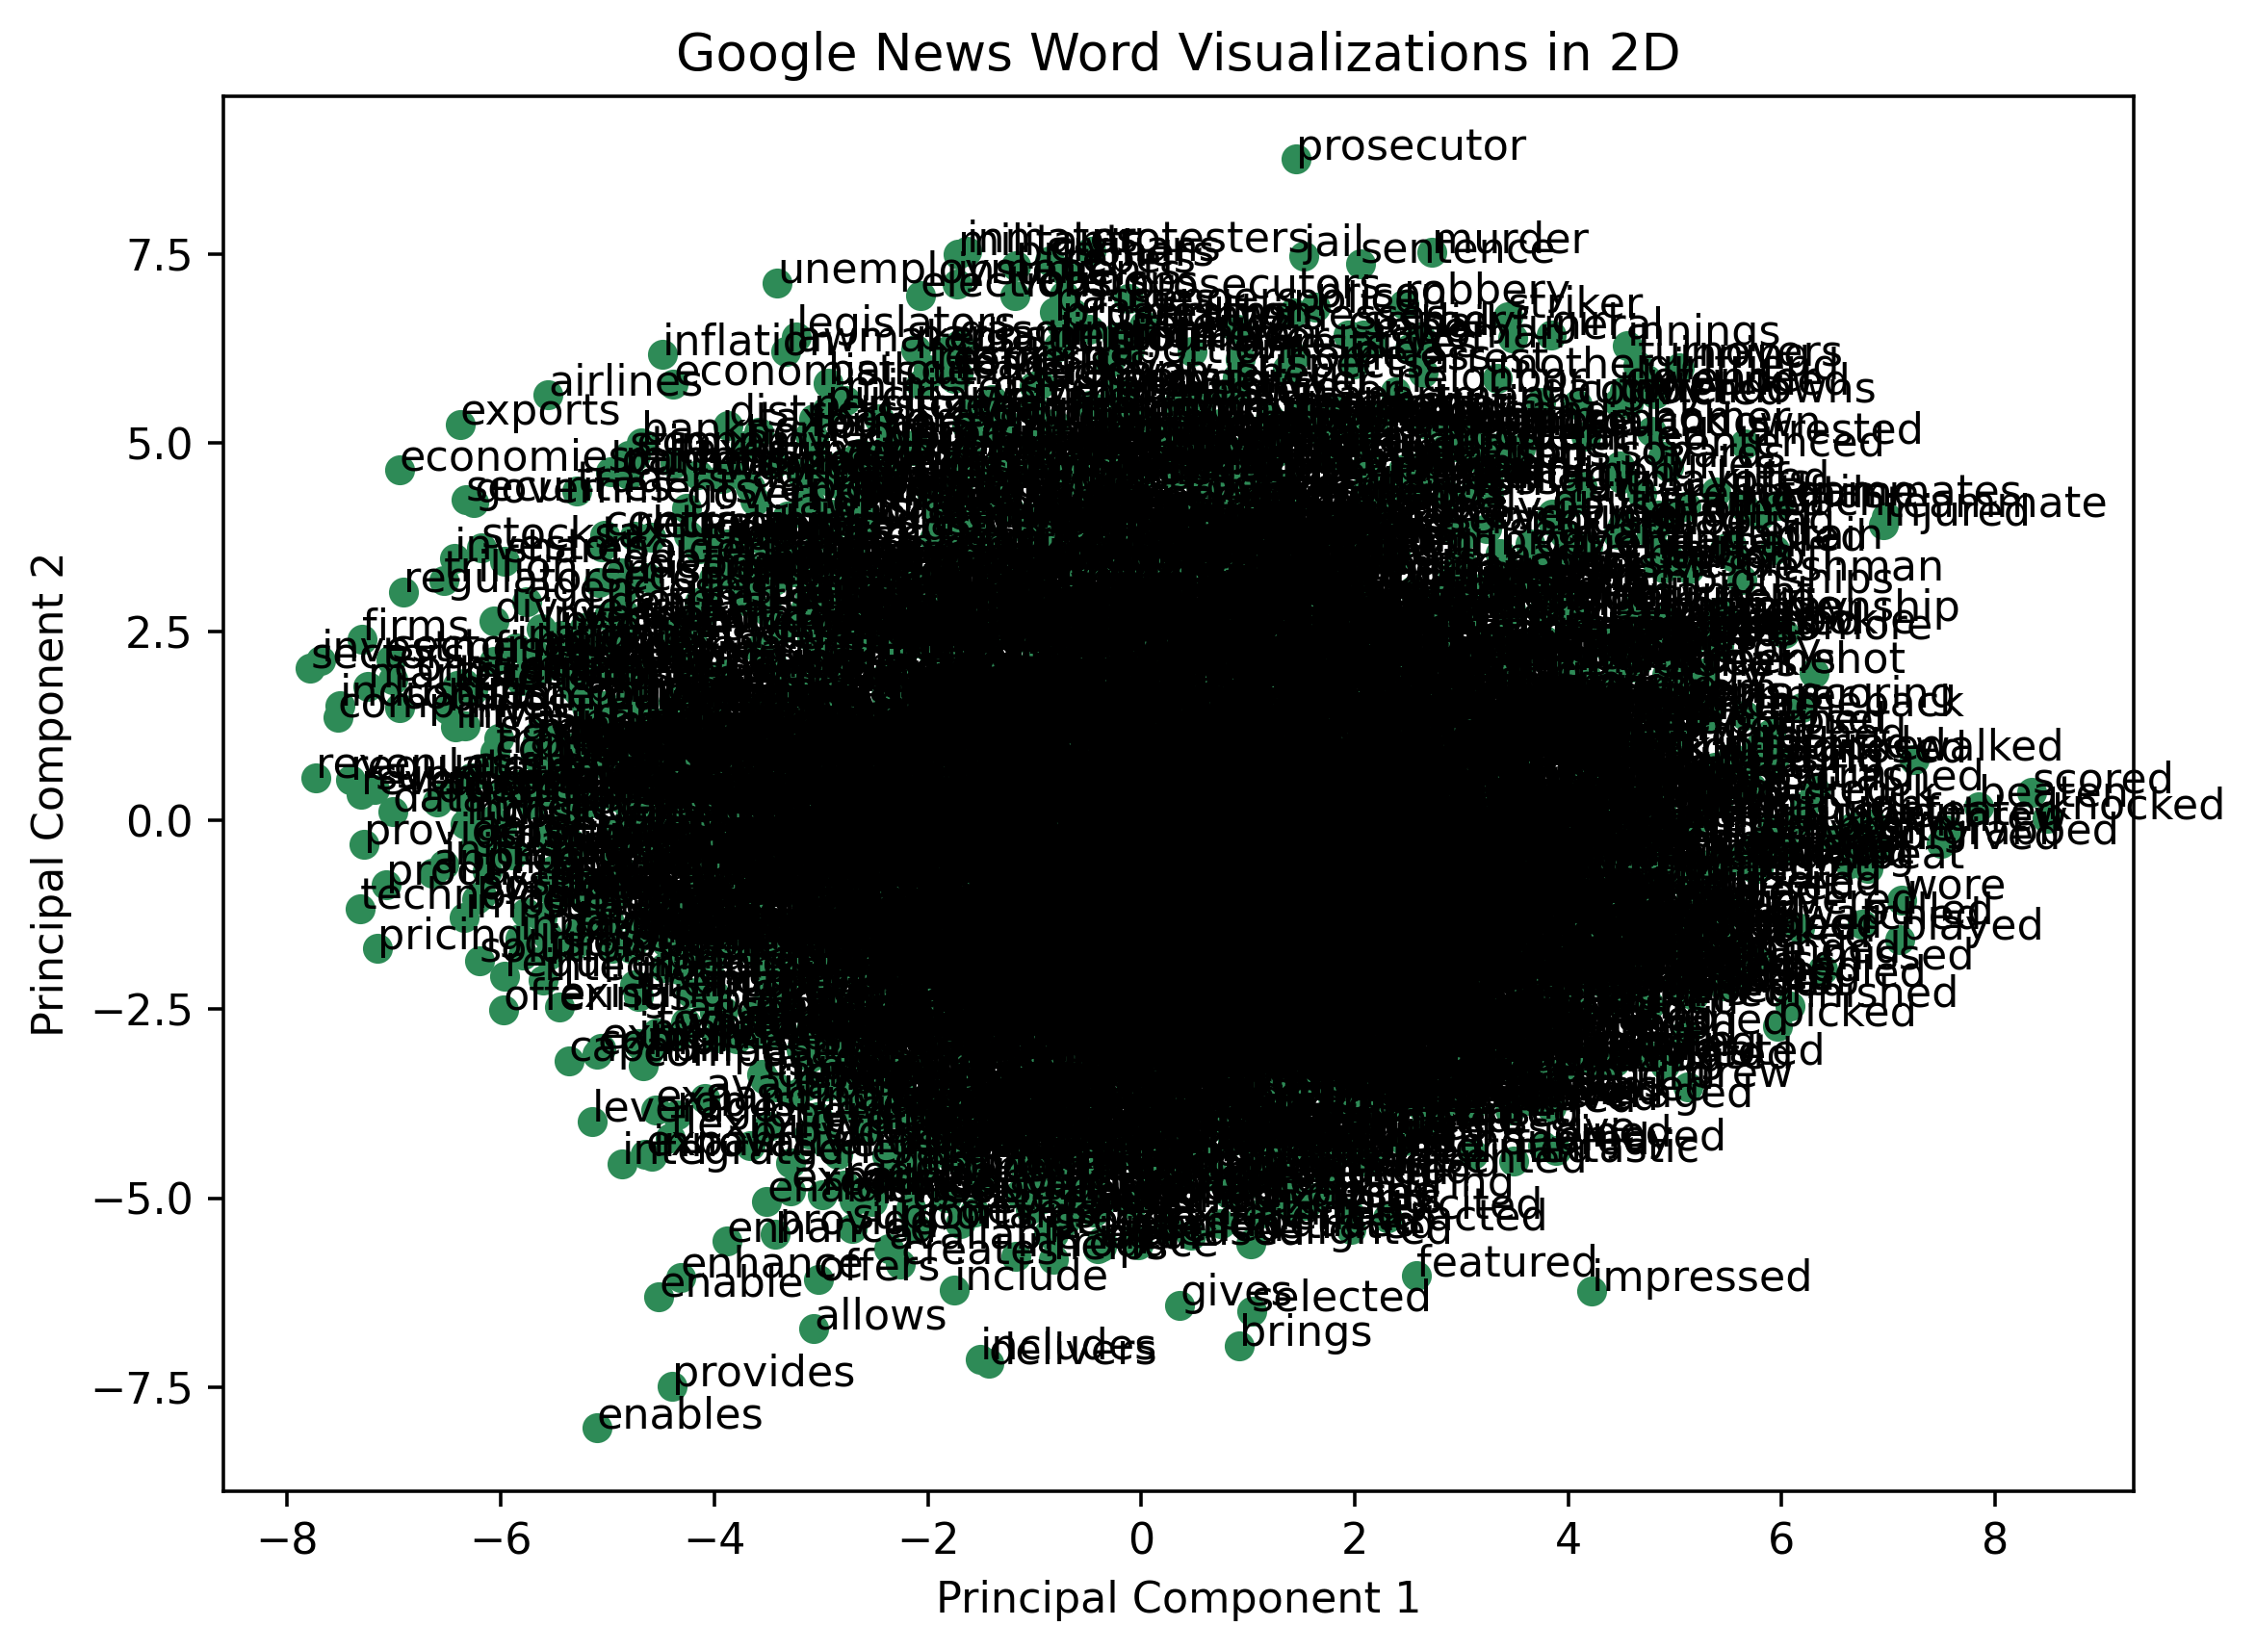

In [ ]:
# plot each word vector
plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(vectors_2d[:,0], vectors_2d[:,1],c="seagreen")
title = "Google News Word Visualizations in 2D"
plt.title(title)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# annotate each point
for i, word in enumerate(pop_cleaned):
    plt.annotate(word, ((vectors_2d[i,0], vectors_2d[i,1])))
plt.savefig(path+title)
plt.show()

It's at this point that you kinda can guess how useful this effort was, although maybe there is some merit to this 2D plotting scheme... For example, you can see at the top left that prosecutor and murder seems to be pretty close to each other, which makes sense in the context of a homicide trial. Also, it seems like a lot of verbs are clustered in this bottom left and interestingly _enable_ and _enables_ are both nearby but _provides_ is much closer to _enables_ than _enable_. As a result, I want to try to two things:
1. Sample a small amount of the words at a time and plot it
2. Color code the words according to part of speech

The first part will give us a less cluttered picture of what's going on, while the second part will be a good look into whether a theoretical clustering of words is actually reflected in the plot.

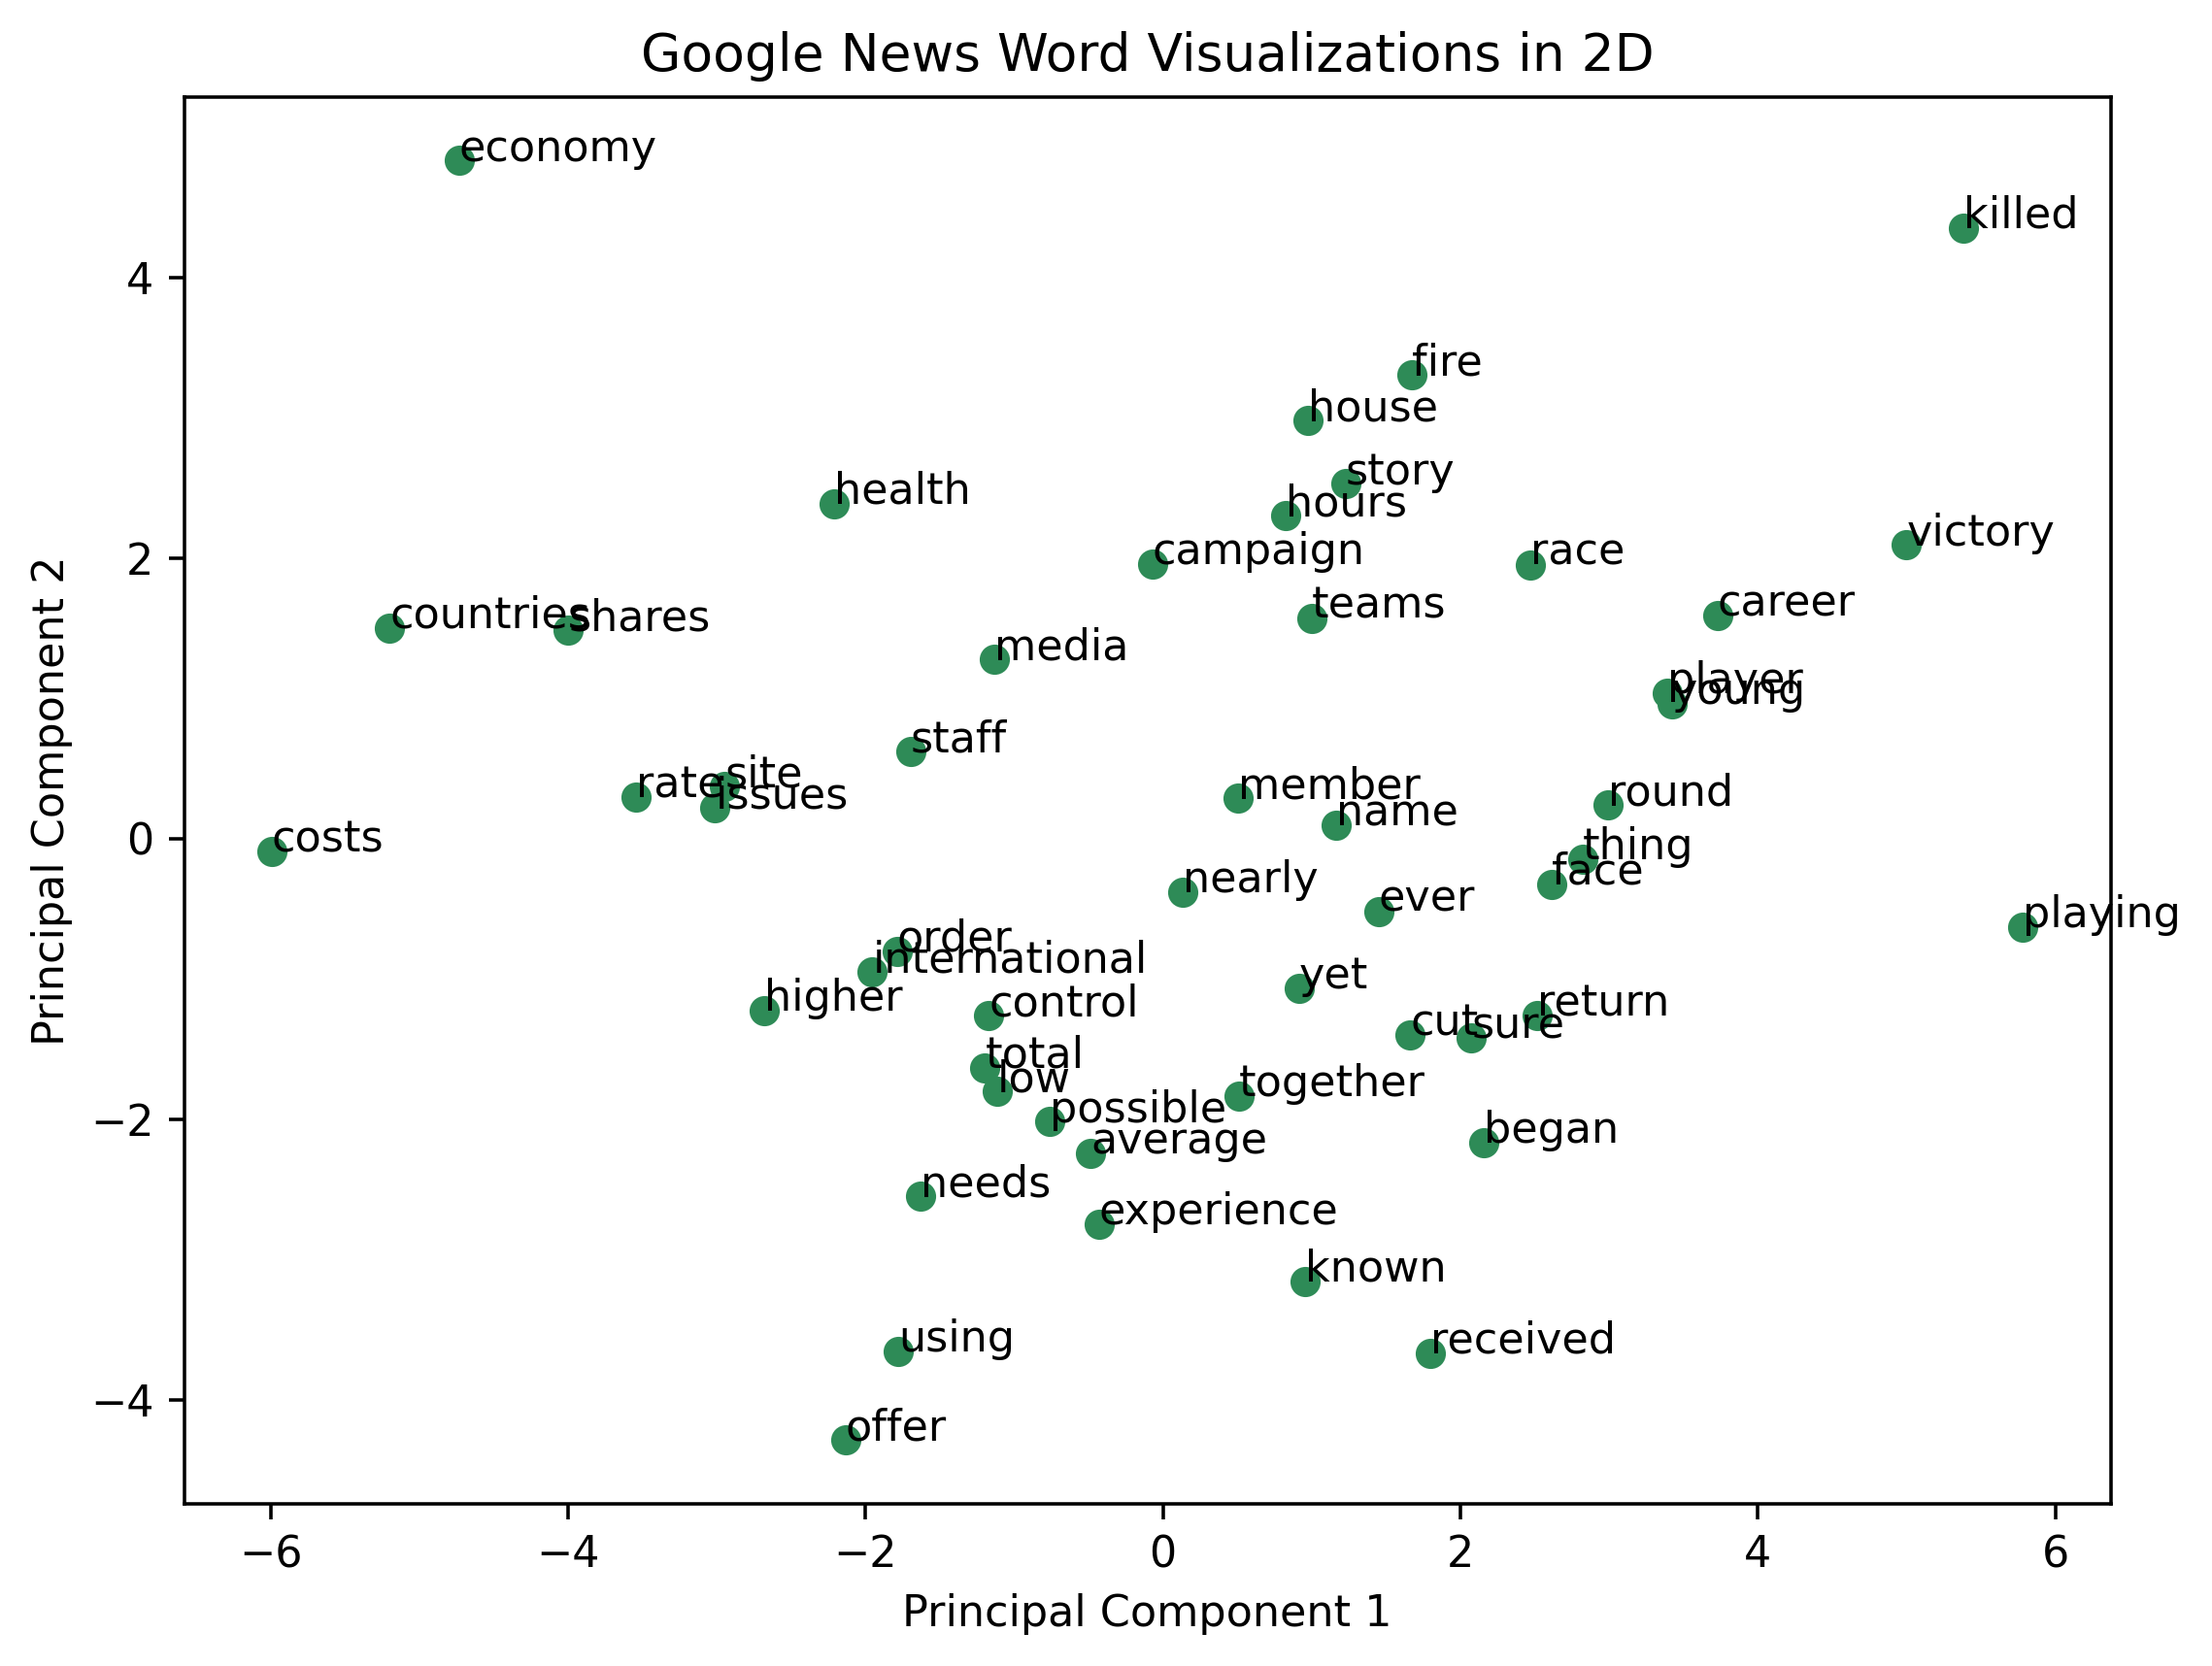

In [ ]:
# plot each word
i,j= 300,350
plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(vectors_2d[i:j,0], vectors_2d[i:j,1],c="seagreen")
title = "Google News Word Visualizations in 2D"
plt.title(title)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# annotate again
for i in range(i,j):
    word = pop_cleaned[i]
    plt.annotate(word, ((vectors_2d[i,0], vectors_2d[i,1])))
plt.savefig(path+title)
plt.show()

In [1]:
# # run for a reminder of the parts of speech
# nltk.help.upenn_tagset()

Unique tags: ['CC' 'CD' 'DT' 'FW' 'IN' 'JJ' 'JJR' 'JJS' 'MD' 'NN' 'NNS' 'PRP' 'RB'
 'RBR' 'RP' 'VB' 'VBD' 'VBG' 'VBN' 'VBP' 'VBZ' 'WDT' 'WP$']


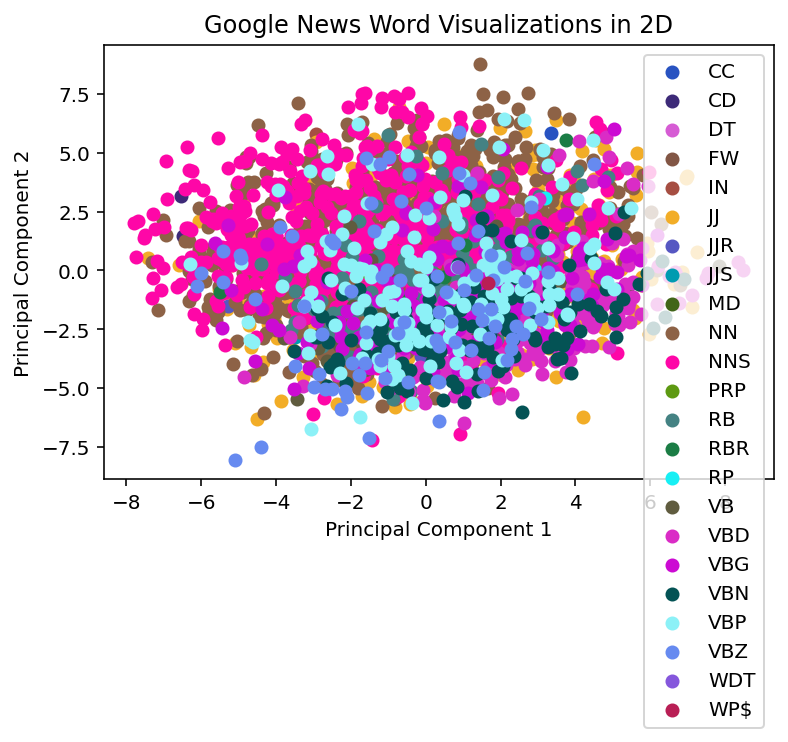

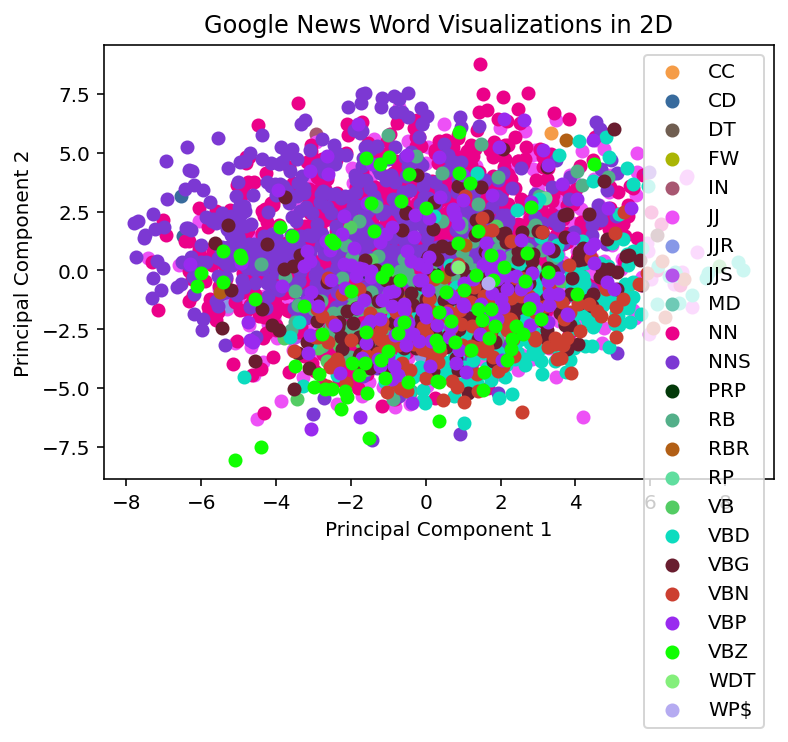

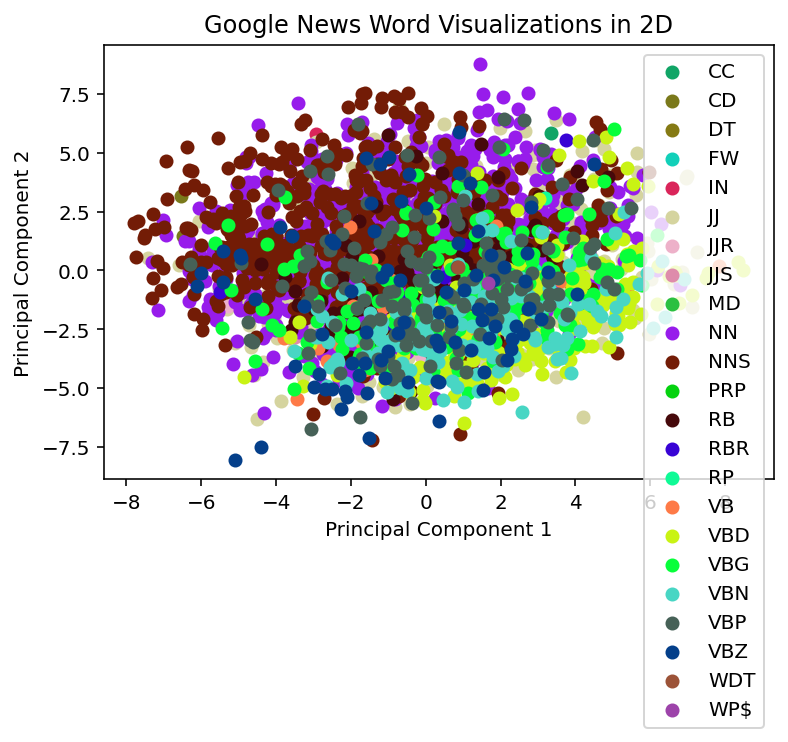

In [ ]:
def get_tagged_plot(vectors, words, num_figures):
  '''plots a certain number of plots given a set of 2D vectors and associated words'''
  # get list of tagged words
  tagged = nltk.pos_tag(words)
  tags = np.array([tag for word,tag in tagged])
  unique_tags=np.unique(tags)
  print("Unique tags:",unique_tags)

  for i in range(num_figures):
    # plot figure using random colors
    plt.figure()
    for tag in unique_tags:
      vectors_tagged = vectors[tags == tag,:]
      plt.scatter(vectors_tagged[:,0], vectors_tagged[:,1], color=np.random.rand((3)), label=tag)

    title = "Google News Word Visualizations in 2D"
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

# may need to run this multiple times to get good colors
get_tagged_plot(vectors_2d, pop_cleaned, 3)

Might be a stretch, but it seems like some clustering (NNS in the top left-hand side) is occurring within the graph. For the most part, I think that from our initial result that only 5% of the original spread is captured in the plot, we won't be able to glean much from this graph. As a final push, I'll plot less of the points and see if it makes a difference

Unique tags: ['CD' 'DT' 'IN' 'JJ' 'JJR' 'JJS' 'MD' 'NN' 'NNS' 'PRP' 'RB' 'RBR' 'RP'
 'VB' 'VBD' 'VBG' 'VBN' 'VBP' 'VBZ' 'WP$']


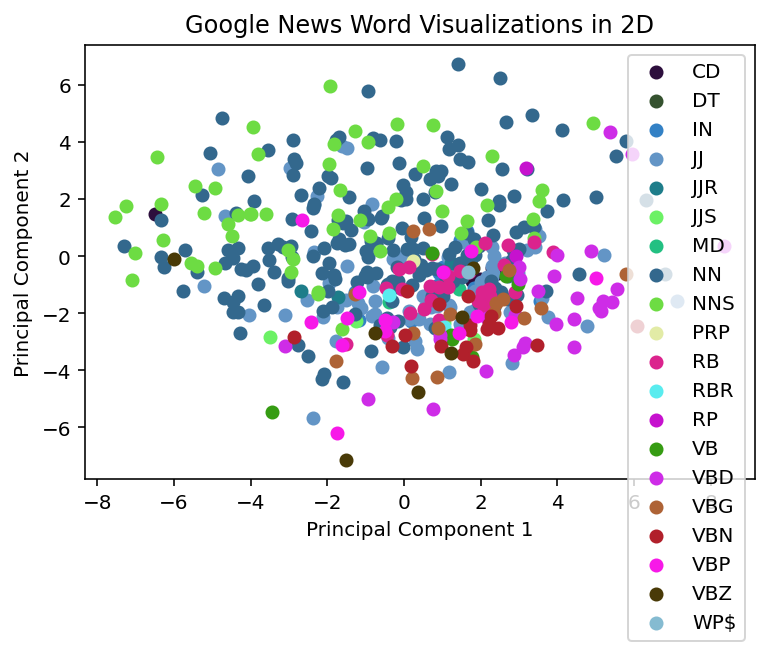

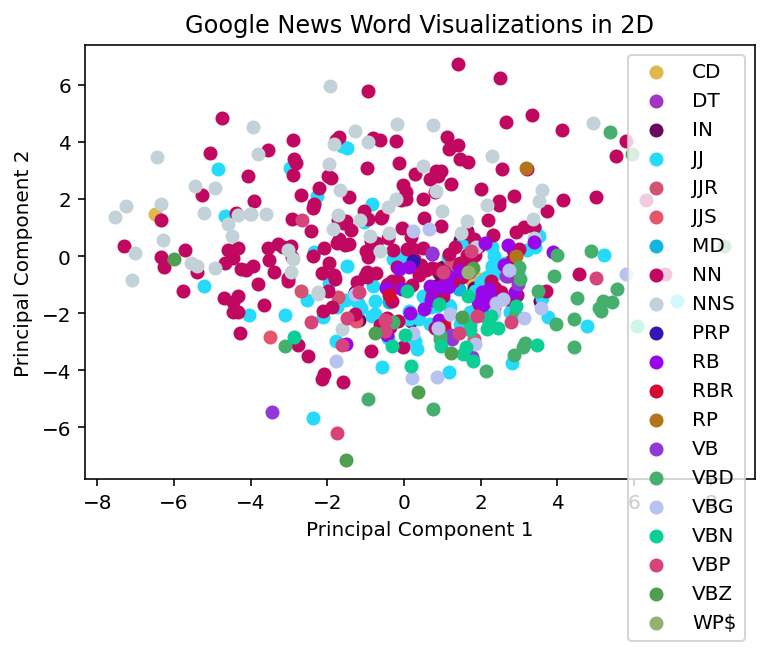

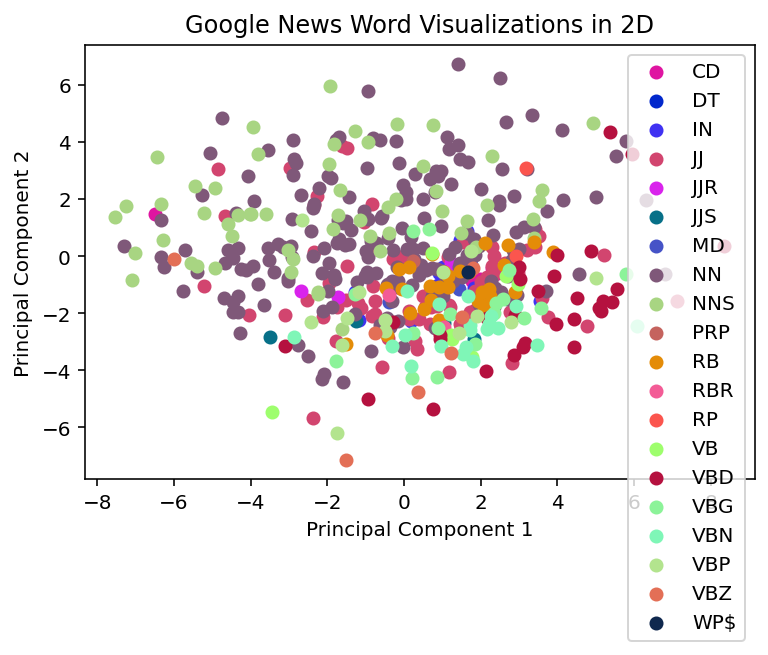

In [ ]:
# run with smaller amount of data
start, stop = 50,550
# may need to run this multiple times to get good colors
get_tagged_plot(vectors_2d[start:stop,:], pop_cleaned[start:stop], 3)

Unfortunately, as expected, not much to glean from this apart form some minimal vague clustering maybe of nouns and other parts of speech, but hard to tell considering the huge overlap between clusters. Let's try a different strategy!

# 🌐 Network Model

An alternative way of clustering! Here we go...

From a class I took on network science, I learned that lots of data that is traditionally not contextualized as a network can be modeled as one. So the question is: what is a network?

A network is a made up of a set of nodes and a set of edges that show relationships in data. For reference, it looks kinda like the FSAs we learned about in class. I will be forming a words network, where each node represent a word in the selected dataset and each edge represents if two words are similar enough (ie above a threshold similarity). My final goal is to try to find clusters within the network and see if I can learn more about the similarities of words from the groupings of each cluster. In other words, it's the same idea as the clustering section with a different setup. The process is as follows...

1. Create a similarity matrix, where each element is the similarity between two words
1. Create an adjacency matrix by thresholding the similarity matrix (this describes which edges are present between which nodes)
1. Create and save a labeled network from the adjacency matrix
1. Repeat steps A-C for different thresholds

Let's dive into it!

In [ ]:
# 1. create similarity matrix for all words
fname = "similarity_matrix"
sim_matrix_path = path+fname+".npy"

# load if already saved
if exists(sim_matrix_path): 
  sim_matrix = np.load(sim_matrix_path)
else:  # otherwise, get pairwise word similarities
  sim_matrix = np.ones((len(pop_cleaned),len(pop_cleaned)))
  for i, word1 in tqdm(enumerate(pop_cleaned)):
    for j in range(i,len(pop_cleaned)):
        word2 = pop_cleaned[j] 
        sim_matrix[i,j] = google_vectors.similarity(word1,word2)
        sim_matrix[j,i] = sim_matrix[i,j]

3713it [05:20, 11.57it/s] 


In [ ]:
# given similarity matrix, find possible thresholds values using mean and std
sim_flattened = sim_matrix.flatten()
mean, std = sim_matrix.mean(), sim_matrix.std()
print(f"mean, std: {mean}, {std}")

print("std \tpercentage of edges maintained")
for i in range(-1,5):
  print(f"{i} stds away: {len(sim_flattened[sim_flattened > mean+i*std])/len(sim_flattened)}")

mean, std: 0.07353506003846978, 0.07662489778060229
std 	percentage of edges maintained
-1 stds away: 0.880697085650326
0 stds away: 0.436288989508405
1 stds away: 0.12847102815832073
2 stds away: 0.03690899322366897
3 stds away: 0.011937225820663875
4 stds away: 0.004374103144925252


In [ ]:
# 2. convert similarity matrix to adjacency matrix based on threshold
scale_factor = 1 # run this for different scale factors (listed above)
threshold = mean + scale_factor*std
adj_matrix = np.array(sim_matrix)

# 1 means an edge is present between two words while 
# 0 means an edge is not present

adj_matrix[adj_matrix >= threshold] = 1
adj_matrix[adj_matrix < threshold] = 0

i,j = 5, 10  # change this to look at a different part of the array
print(f'''
Threshold: {threshold}

Similarity Matrix...\n" {pop_cleaned[i:j]}
{sim_matrix[i:j,i:j]}

Adjacency Matrix...\n" {pop_cleaned[i:j]}
{adj_matrix[i:j,i:j]}
''')


Threshold: 0.15015995781907207

Similarity Matrix...
" ['two' 'first' 'time' 'last' 'new']
[[1.         0.32014284 0.24487995 0.32790798 0.15018491]
 [0.32014284 1.         0.32763773 0.58422196 0.27770245]
 [0.24487995 0.32763773 1.         0.24865276 0.1287725 ]
 [0.32790798 0.58422196 0.24865276 1.         0.18659709]
 [0.15018491 0.27770245 0.1287725  0.18659709 1.        ]]

Adjacency Matrix...
" ['two' 'first' 'time' 'last' 'new']
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]]



In [ ]:
# 3. create and save network
# create initial network
G_unlabeled = nx.from_numpy_matrix(adj_matrix)

# associate each word with a node
assert len(pop_cleaned) == len(adj_matrix), f"number of words don't match matrix dimensions {len(pop_cleaned)} {len(adj_matrix)}"
words = [str(word) for word in pop_cleaned] # convert back to python list to save file in the future
mapping = dict([(i,word) for i,word in enumerate(words)])
G = nx.relabel_nodes(G_unlabeled, mapping)
print(f"Example nodes: {list(G.nodes)[:5]}")

Example nodes: ['said', 'year', 'one', 'would', 'also']


In [ ]:
# get and label PoS for each node in network (labels stored in a dict)
tagged = nltk.pos_tag(words)
tags = [tag for word,tag in tagged]

i = 0
for node,data in G.nodes(data=True):
  data['pos'] = tags[i]
  i+=1

list(G.nodes(data=True))[:5]

[('said', {'pos': 'VBD'}),
 ('year', {'pos': 'NN'}),
 ('one', {'pos': 'CD'}),
 ('would', {'pos': 'MD'}),
 ('also', {'pos': 'RB'})]

In [ ]:
# calculate optimal network communities (clusters)
partition = community.best_partition(G)
print(f"Number of partitions: {np.max(list(partition.values()))+1}")

Number of partitions: 5


In [ ]:
# add node partitions (numbers represent the cluster number it's associated to)
for node, data in G.nodes(data=True):
  data['partition'] = partition[node]

list(G.nodes(data=True))[:5]

[('said', {'partition': 0, 'pos': 'VBD'}),
 ('year', {'partition': 2, 'pos': 'NN'}),
 ('one', {'partition': 0, 'pos': 'CD'}),
 ('would', {'partition': 0, 'pos': 'MD'}),
 ('also', {'partition': 3, 'pos': 'RB'})]

In [ ]:
# save network
nx.write_gexf(G, f"{path}networks/word_graph_{scale_factor}.gexf")

# 👀 Visualizations

With all the clunky stuff out of the way, let's see where all this hard work went! We'll go through them one by one, but for now, just enjoy them!

**Parts of Speech Legend**

![](https://drive.google.com/uc?export=view&id=1BllFnX1zJphzFeyKv1feiAPeDIM2w4-2)


**Fig 1: Unlabeled with Parts of Speech Clusters**

![](https://drive.google.com/uc?export=view&id=14rGz-nHbpWt_R7E9X3oRvmRGmHnHcEyt)

**Fig 2: Unlabeled Words with Algorithm Clusters**

![](https://drive.google.com/uc?export=view&id=1liahO3sqr8tF0rTXI4SjOMSS01kAX7Yz)

**Fig 3: Labeled with Parts of Speech Clusters**

![](https://drive.google.com/uc?export=view&id=1dk5_wlD0kyPerYcuTjaDYSVztMY00-OK)

**Fig 4: Labeled Words with Algorithm Clusters**

![](https://drive.google.com/uc?export=view&id=1a7NCWWcTKR1TXljTCRR5qqf3zasV_iXS)


![](https://drive.google.com/uc?export=view&id=ID_GOES_HERE)

From the parts of speech legend, nouns as a whole take up almost half of the graph. This might be intepretable as the frequent topics that are often discussed in news articles (input data) including politics, sports, and money. Verbs are the second most frequent, followed by adjectives, and then adverbs. (Note that this does not add up to 100% because there are smaller categories that are just given a grey coloring.)

As you can see, the parts of speech clusters are a little hazy in their clustering, while the algorithmic partitioning is much cleaner. The goal of Figures 1 and 2 is to get an intuitive feel for these clusters. Generally, the verbs seem to cluster in the top middle, the adverbs relatively densely clustered in the top left middle, adjectives mingling with adverbs and other categories, and nouns taking up most of the space from the bottom to the right side. It also seems important to show that singular and plural nouns are well mixed into each other, which might indicate how both context and parts of speech are encoded in the similarity score \[Spoiler alert! It really look like it does!\] This will be better explained by the set of labeled graphs.

---

_Aside: Though some might argue that this looks incredibly similar to the plots in the first clustering graph section, I would argue that less information is lost here. While the PCA tries to compress the data into 2 dimensions without comparisons, instead only 1 dimension (similarity) is used but it is most relevant to comparisons of words. In doing so, though there is still a very globular look to this current graph. Despite this, a healthy criticism of methods is still important to be aware of the limitations of network clustering._

The goal of Figure 3 and 4 is to give you a sense of which words tend to be similar to each other based on how many neighbors (nodes one hop away) they have. Zooming in on the graph, adverbs like _certainly_, _probably_, and _maybe_ seem to take up nearby space, as shown when we just isolate the neighborhood of _certainly_, ie all the neighbors of _certainly_:

![](https://drive.google.com/uc?export=view&id=1lJeEHGmnlqqhRRNB6JlLp74q1h6O8puO)

It seems like both parts of speech and semantics is encoded, as words like _simply_, _entirely_ and _obviously_ that have similar meanings are closely surrounding _certainly_. On the contrary, words like _maybe_, _hopefully_, and _perhaps_ are a slighly farther distance away but could definitely be used in the same type of context. (Despite this, I will refrain from purely assessing distances, as the way the network is arranged is kind of a black box to me) Not sure what to make of it, but it is interesting to note that a lot of non-adverb words have high similarity as well, ranging from plurals nouns (_things_) to past tense verbs (_insisted_) to adjectives (_enormous_). Let me know if you think there's something cool here, cause I don't have the linguistics finesse to analyze this one....

![](https://drive.google.com/uc?export=view&id=ID_GOES_HERE)

The same sort of grouping occurs for verbs as well. Here is the neighborhood of _demonstrated_:
![](https://drive.google.com/uc?export=view&id=1CIJNpXrEcamTHx8cao5_HLNyUHivPtHC)


![](https://drive.google.com/uc?export=view&id=1y9qVCzApDHQ0Z4Q2lHu3lI4PFNRx5fYQ)


As expected, a lot of the words seem to be past tense verbs, however some of these words seem to be very different in meaning, a lot less than the _certainly_ neighborhood. For instance, _praised_, _declared_, _considered_, _concluded_, and _promised_ all cluster near _demonstrated_. In these set of words, _concluded_ and maybe _declared_ might be the best synonym, but the rest are more fuzzy in comparing purely definitions. This is the first example of how semantic similarity is not the sole similarity measure encoded in Semantle (but Contextle does not really roll off the tongue like Semantle does, huh?). Another interesting part of this neighborhood is the labeling of words like _convinced_, _described_, and _highlights_, which are all verbs but are labeled as an adjective, noun, and plural noun. As promised by the creator of Semantle on his website, some similarities may not necessarily line up with parts of speech and the other way around, as the part of speech of some word are context-dependent. While in context, the first and last makes sense, _described_ as a noun is surprising. Either an anomaly in the tagger or a small error on my part, this  goes to show that the context system is not perfect in terms of how we colloquially understand word meanings and their similarity.

This is not the whole neighborhood of _demonstrated_...

![](https://drive.google.com/uc?export=view&id=ID_GOES_HERE)

![](https://drive.google.com/uc?export=view&id=1y9qVCzApDHQ0Z4Q2lHu3lI4PFNRx5fYQ)

In this portion of the network, there seems to be a clear trend towards the context of energy (_gas_, _nuclear_,  _power_) and slightly of warfare (_arms_, _weapons_, _terrorism_, _allies_). This is interesting as it gives meaning to the way _demonstrated_ seems to be used in the context of news articles: past demonstrations of warfare or past demonstrations of changes in energy usage. This finding is particularly exciting, as it shows that similarity not only encodes part of speech, but also encodes the word’s context within the input articles used. This ability to both explain word similarity and context explication can likely be attributed to the Word2Vec model used to learn these similarities with its continuous bag of words and continuous skipgram architecture. To wrap things up, let’s take a look at some noun neighborhoods, particularly _banking_ and _marijuana_:

![](https://drive.google.com/uc?export=view&id=13cCH5oSQ3dS9yWCq1xwqRzkZ-npolArE)

With the _banking_ neighborhood, there is a clear business context encoded in the neighborhood, ranging from farther-off words like agricultural and regulatory to expected words like _markets_ and _businesses_. Interesting enough, while the majority of words are nouns, they seem to be split between plural and singular nouns, which expands on the idea that part of speech is just one element of similarity. For the _marijuana_ neighborhood, there is a clear context of drugs  (_drugs_, _smoking_) and criminality (_arrested_, _felony_) involved in this small neighborhood. Intuitively, there seems to be an argument to make that words with small neighborhood might encode the uniqueness of a word. Why? If a word is unique in its usage and context in texts, then it will have relatively lower similarity scores with other words. Overall lower similarity means that a fewer number of words are above the similarity threshold, leading to less neighborhood overlap. While this seems to makes sense, more evidence would be needed to investigate this claim. 

# 🥧 Summary

So what have we learned?

From dimension reduction to network science, we learned quickly that dimension reduction loses a lot of the spread of the data. From there, we instead used word similarity as a metric for comparison, creating networks that were both labeled and unlabeled as well as color coded separately with the optimal partition and each word’s parts of speech. From the unlabeled networks, it was clear to see that the encoding of word similarity was not purely parts of speech, as we saw with words like _demonstrated_. Instead, likely due to the Word2Vec construction of word embeddings, context of the word in the articles was also encoded, where _demonstrated_ seemed to be used in energy and warfare contexts, _marijuana_ was (unfortunately but predictably) used in a criminal context, and _banking_ was business as usual. While on the surface networks seems to look like a fancy version of the PCA, being able to encode the similarities of words in an interactive way helped us see that Semantle (and Word2Vec’s) similarity measures are a multidimensional encoding of words including at least their parts of speech and context.

Thanks for tuning in! Hope you enjoyed this little analysis and feel free to let me know if there's more fun to be done!

---

**PS:** Because work is never done and the pursuit of knowledge is never-ending, here are some future steps I came up with for myself or anyone else willing to investigate…
- Using more quantitative/network-wide measures to corroborate these specific examples
- Substantiating the claim that smaller neighborhoods indicate more unique words
- Changing the creation of the adjacency matrix: doing only topic-specific words in the network or creating edges between the top 100 similar words for each word. The former could be an investigation into the relationship of words and the latter could make the network more consistent, as some words have relatively few words to compare to. 
- Working on making the clustering visualization more clsutered
- Using this sort of technique as a way to do advanced text reproduction for specific topics (like a chatbot application of sorts)

The awesome thing about network science and this method in general is that it is so readily adaptable to different problem formulations and research questions that it feels like a never-ending playground to use! And with that, I hope you all also get to playing as well! This seems like just the tip of the iceberg in terms of network analysis of semantics.